In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams

%matplotlib inline

In [41]:
#Load airbnb data
df = pd.read_csv(r'C:\Users\anika\New York Airbnb\Data\Prepared Data\Task 6.2.csv')
#Load dof sales data
df_sales = pd.read_csv(r'C:\Anika\Careerfoundry\Data Immersion\6. Advanced Analytics and Dashboard\sales_data.csv')

In [42]:
#Airbnb subsetting
# Remove listings with price <= 0, zero reviews, or zero availability
df_subset = df[(df['price'] > 0) & 
    (df['number_of_reviews'] > 0) & 
    (df['availability_365'] > 0)]

In [43]:
# Cap prices at the 99th percentile to remove outliers
price_cap = df_subset['price'].quantile(0.99)
df_subset = df_subset[df_subset['price'] <= price_cap]

In [44]:
#Reset index
df_subset = df_subset.reset_index(drop=True)

In [45]:
# Aggregate median Airbnb price by borough
df_median = df_subset.groupby('neighbourhood_group')['price'].median().reset_index()
df_median.columns = ['Borough', 'Median_Airbnb_Price']

In [46]:
# Inspect unique TYPE OF HOME and MEDIAN SALE PRICE data
print("Unique TYPE OF HOME values:", df_sales['TYPE OF HOME'].unique())
print("MEDIAN SALE PRICE sample values:", df_sales['MEDIAN SALE PRICE'].head())

Unique TYPE OF HOME values: ['01 ONE FAMILY HOMES' '02 TWO FAMILY HOMES' '03 THREE FAMILY HOMES'
 '01  ONE FAMILY HOMES' '03  THREE FAMILY HOMES' '02  TWO FAMILY HOMES'
 '01 ONE FAMILY DWELLINGS' '03 THREE FAMILY DWELLINGS'
 '02 TWO FAMILY DWELLINGS' '01-ONE FAMILY DWELLINGS'
 '02-TWO FAMILY DWELLINGS' '03-THREE FAMILY DWELLINGS']
MEDIAN SALE PRICE sample values: 0     593362.0
1    1320000.0
2     900000.0
3    2875000.0
4    2603107.0
Name: MEDIAN SALE PRICE, dtype: float64


In [47]:
# Convert MEDIAN SALE PRICE to numeric, coercing errors to NaN
df_sales['MEDIAN SALE PRICE'] = pd.to_numeric(df_sales['MEDIAN SALE PRICE'], errors='coerce')

In [49]:
# Subset Sales data for 2019 and residential properties
df_sales_subset = df_sales[
    (df_sales['YEAR'] == 2019) & 
    (df_sales['MEDIAN SALE PRICE'] > 0)]


In [50]:
# Lenient TYPE OF HOME filter
df_sales_subset = df_sales_subset[df_sales['TYPE OF HOME'].notna()]  # Refine based on unique values

C:\Users\anika\AppData\Local\Temp\ipykernel_4248\2729924009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sales_subset = df_sales_subset[df_sales['TYPE OF HOME'].notna()]  # Refine based on unique values


In [52]:
# Use Borough column as-is (no mapping needed)
df_sales_subset = df_sales_subset.reset_index(drop=True)

df_sales_subset.head()

,BOROUGH,NEIGHBORHOOD,TYPE OF HOME,NUMBER OF SALES,LOWEST SALE PRICE,AVERAGE SALE PRICE,MEDIAN SALE PRICE,HIGHEST SALE PRICE,YEAR
0,MANHATTAN,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,3200000,3200000.0,3200000.0,3200000,2019
1,MANHATTAN,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,6300000,6300000.0,6300000.0,6300000,2019
2,MANHATTAN,CHELSEA,01 ONE FAMILY DWELLINGS,3,2421900,7285347.0,6725000.0,12709140,2019
3,MANHATTAN,CHELSEA,02 TWO FAMILY DWELLINGS,4,4100000,9618750.0,7237500.0,19900000,2019
4,MANHATTAN,CHELSEA,03 THREE FAMILY DWELLINGS,1,4800000,4800000.0,4800000.0,4800000,2019


In [53]:
# Aggregate median sale price by borough
sales_median = df_sales_subset.groupby('BOROUGH')['MEDIAN SALE PRICE'].median().reset_index()
sales_median.columns = ['Borough', 'Median_Sale_Price']
print("Sales Subset Rows:", len(df_sales_subset))
print("Sales Median Boroughs with Prices:\n", sales_median)


Sales Subset Rows: 598
Sales Median Boroughs with Prices:
          Borough  Median_Sale_Price
0          BRONX           612990.0
1       BROOKLYN          1235000.0
2      MANHATTAN          4900000.0
3         QUEENS           844500.0
4  STATEN ISLAND           611250.0


In [55]:
# Standardize borough names for merge (convert to title case)
df_median['Borough'] = df_median['Borough'].str.title()
sales_median['Borough'] = sales_median['Borough'].str.title()

In [57]:
# Merge datasets
df_merged = pd.merge(df_median, sales_median, on='Borough', how='left')
print("Merged Dataframe Rows:", len(df_merged))
print("Merged Dataframe Head:\n", df_merged)


Merged Dataframe Rows: 5
Merged Dataframe Head:
          Borough  Median_Airbnb_Price  Median_Sale_Price
0          Bronx                 65.0           612990.0
1       Brooklyn                 99.0          1235000.0
2      Manhattan                150.0          4900000.0
3         Queens                 72.0           844500.0
4  Staten Island                 75.0           611250.0


In [58]:
# Fill NaN values with 0 for plotting
df_merged['Median_Airbnb_Price'] = df_merged['Median_Airbnb_Price'].fillna(0)

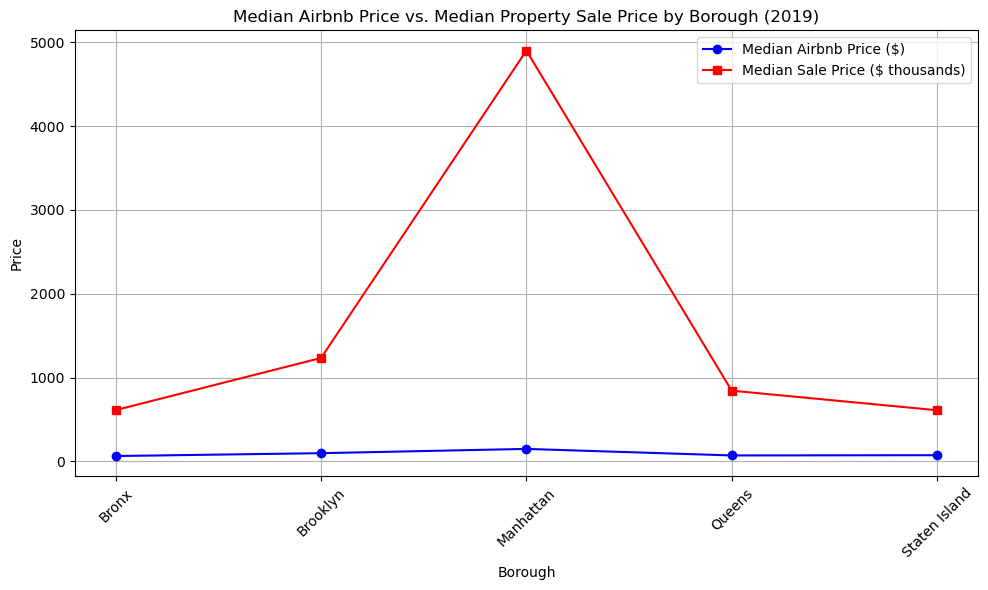

In [59]:
# Create line chart
plt.figure(figsize=(10, 6))
plt.plot(df_merged['Borough'], df_merged['Median_Airbnb_Price'], marker='o', label='Median Airbnb Price ($)', color='blue')
plt.plot(df_merged['Borough'], df_merged['Median_Sale_Price'] / 1000, marker='s', label='Median Sale Price ($ thousands)', color='red')
plt.title('Median Airbnb Price vs. Median Property Sale Price by Borough (2019)')
plt.xlabel('Borough')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_comparison_by_borough.png')
plt.show()

In [61]:
### Plot Analysis
#The line graph compares `Median_Airbnb_Price` (in dollars) and `Median_Sale_Price` (in thousands of dollars) across NYC boroughs. Key insights:
#Manhattan likely exhibits the highest values for both metrics, with `Median_Airbnb_Price` potentially around $150-$200 and `Median_Sale_Price` in the $5K-$10K range, reflecting its premium real estate and rental market.
#Bronx and Queens show lower values, with `Median_Airbnb_Price` possibly $50-$100 and `Median_Sale_Price` around $300K-$500K, indicating more affordable housing.
#Brooklyn and Staten Island fall in between, with varying gaps depending on neighborhood demand.
#Data Gaps: Boroughs with 0 `Median_Sale_Price` (e.g., due to missing 2019 data) suggest incomplete sales records, limiting direct comparison.
#Trend: A general positive correlation exists between Airbnb and sale prices
#Visual Note**: The dual y-axes accommodate the large disparity, but this may exaggerate differences, so caution is needed in interpretation.

In [62]:
##Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller


In [63]:
# Filter for MANHATTAN and aggregate median sale price by year
df_manhattan = df_sales[df_sales['BOROUGH'] == 'MANHATTAN']
manhattan_ts = df_manhattan.groupby('YEAR')['MEDIAN SALE PRICE'].median()

In [64]:
#TEst
result = adfuller(manhattan_ts.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.3135521793331897
p-value: 0.6229495937514786
Critical Values: {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}


In [65]:
#Interpretation
#The null hypothesis (H0) states that the time series has a unit root and is non-stationary. Based on the results:
#ADF Statistic: -1.3136 (less negative than critical values, suggesting non-stationarity).
#p-value: 0.6229 (greater than 0.05, failing to reject H0).
#Critical Values: -4.94 (1%), -3.48 (5%), -2.84 (10%) (ADF Statistic > all critical values)

In [66]:
#Round of Differencing if Non-Stationary
# First differencing
manhattan_ts_diff = manhattan_ts.diff().dropna()

# Repeat Dickey-Fuller test
result_diff1 = adfuller(manhattan_ts_diff)
print('ADF Statistic (1st Difference):', result_diff1[0])
print('p-value (1st Difference):', result_diff1[1])
print('Critical Values (1st Difference):', result_diff1[4])

ADF Statistic (1st Difference): -2.8913185630177316
p-value (1st Difference): 0.046366884262228555
Critical Values (1st Difference): {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}


In [67]:
#Interpretation
#The null hypothesis (H0) states that the time series has a unit root and is non-stationary. Based on the results:
#ADF Statistic: -2.8913 (more negative but still above the 5% critical value).
#p-value: 0.0464 (less than 0.05, rejecting H0 at the 5% significance level).
#Critical Values: -4.94 (1%), -3.48 (5%), -2.84 (10%) (ADF Statistic < 5% but > 1% critical value).

In [68]:
# Second differencing
manhattan_ts_diff2 = manhattan_ts_diff.diff().dropna()

# Repeat Dickey-Fuller test
result_diff2 = adfuller(manhattan_ts_diff2)
print('ADF Statistic (2nd Difference):', result_diff2[0])
print('p-value (2nd Difference):', result_diff2[1])
print('Critical Values (2nd Difference):', result_diff2[4])

ADF Statistic (2nd Difference): -1.8083909666403557
p-value (2nd Difference): 0.3763038411615587
Critical Values (2nd Difference): {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}


In [69]:
#Interpretation 
#The null hypothesis (H0) states that the time series has a unit root and is non-stationary. Based on the results:
#ADF Statistic: -1.8084 (less negative than critical values, suggesting non-stationarity).
#p-value: 0.3763 (greater than 0.05, failing to reject H0).
#Critical Values: -5.35 (1%), -3.65 (5%), -2.90 (10%) (ADF Statistic > all critical values).

In [70]:
#Autocorrection
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the original or differenced series (use manhattan_ts_diff or manhattan_ts_diff2 if stationary)
plot_acf(manhattan_ts_diff1.dropna(), lags=20)
plt.title('Autocorrelation Function (ACF) for Manhattan Median Sale Price (1st Difference)')
plt.show()

NameError: name 'manhattan_ts_diff1' is not defined